In [1]:
import os
import time
import torch
import torch as nn
import numpy as np
import torchvision
from PIL import Image
from networks import *
from models import *
import matplotlib.pyplot as plt
from torchvision import transforms
import sklearn.neighbors as N
from scipy.optimize import minimize, LinearConstraint

model_dir = './'

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    npimg = np.transpose(np.clip(npimg, 0, 1), (1, 2, 0))
    plt.imshow(npimg)
    plt.show()
    return npimg

transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize((0.5), (0.5))])

In [2]:
ae_model = Component_AE({'CAE_norm': 'instance'}, 'face', False).cuda()
ae_model.load_state_dict(torch.load(os.path.join(model_dir, 'ae_model_100ep.pt')))

for p in ae_model.parameters(): p.requires_grad = False
ae_model.eval()

encoder = ae_model.encoder
encoder.eval()
decoder = ae_model.decoder
decoder.eval()

Decoder_Res(
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=131072, bias=True)
  )
  (conv): Sequential(
    (0): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
        (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
        (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): DecoderBlock(
      (conv): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (2): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 

In [11]:
# return numpy array
vectors_np = torch.load('../filtered_lib(75).pt')

In [12]:
k = 10
neigh = N.NearestNeighbors(n_neighbors=k)
neigh.fit(vectors_np)

NearestNeighbors(n_neighbors=10)

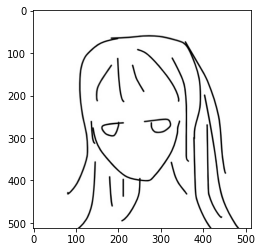

In [13]:
path_to_test_sketch='../TEST DATA/test21.jpeg'

def get_neighbors(k, neigh, path_to_test_sketch):
  
  img = Image.open(path_to_test_sketch).convert('L')
  img = transform(img)
  input = img.unsqueeze(0)
  imshow(torchvision.utils.make_grid(img[0]))
  latent = encoder(input.cuda()).cpu().numpy()
  # this returns indices of neighbors
  idx = np.squeeze(neigh.kneighbors(latent, k, return_distance=False))
  nns = vectors_np[idx,:]

  return latent, nns

latent, nns = get_neighbors(k, neigh, path_to_test_sketch)

def setup(k, latent, nns):

  constraint = LinearConstraint(np.ones((1,k)), lb=1, ub=1)
  def objective_function(x):
      return np.sqrt(np.sum((latent - np.sum((x*nns.T).T,0))**2))
  
  return objective_function, constraint

objective_function, constraint = setup(k, latent, nns)

res = minimize(
    objective_function,
    x0=np.random.random((k)),
    constraints=constraint,
)

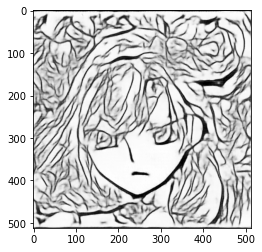

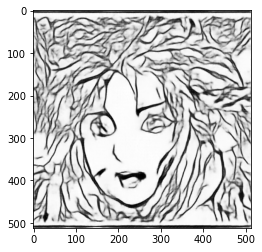

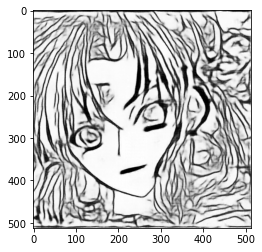

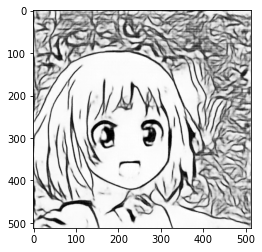

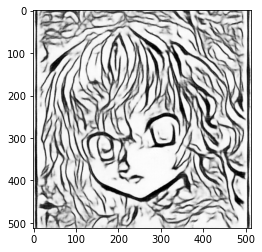

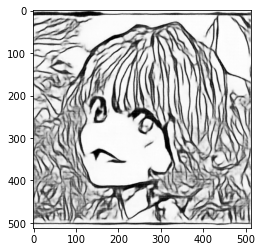

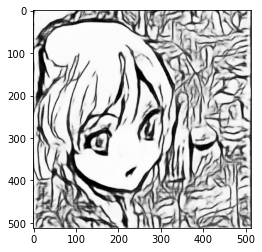

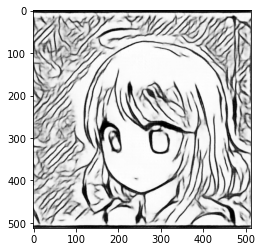

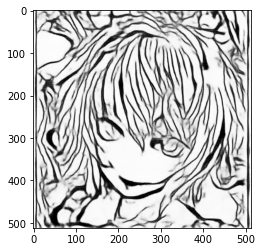

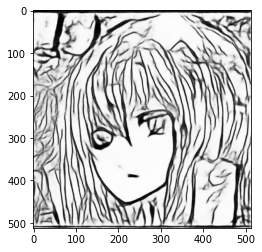

In [14]:
# show the k neighbors
for i in range(k):
  proj_latent = torch.from_numpy(nns[i]).to(device).unsqueeze(0).float()
  output = decoder(proj_latent)
  imshow(torchvision.utils.make_grid(output[0].cpu()))

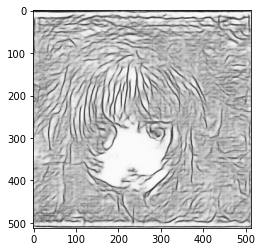

In [15]:
# projected latent vector by optimization
proj_latent = torch.from_numpy(np.sum((res.x*nns.T).T, 0)).to(device).unsqueeze(0).float()
output = decoder(proj_latent)
plot = imshow(torchvision.utils.make_grid(output[0].cpu()))

In [8]:
im = Image.fromarray((plot * 255).astype(np.uint8))
im.save('result.jpg')

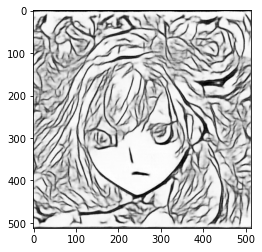

In [16]:
# we can also manually change weights
manual_weights = np.array([0.9,0.1,0,0.1,0,0,0,0,0,0]) # change numbers here
proj_latent = torch.from_numpy(np.sum((manual_weights*nns.T).T,0)).to(device).unsqueeze(0).float()
output = decoder(proj_latent)
plot = imshow(torchvision.utils.make_grid(output[0].cpu()))

In [10]:
im = Image.fromarray((plot * 255).astype(np.uint8))
im.save('result.jpg')